In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from astroddpm.diffusion.power_spectra.powerspec_sampler import CMB_H_OMBH2
from astroddpm.analysis.validationMetrics.powerSpectrum import _spectral_iso2d

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
ps_model = CMB_H_OMBH2().to(device)

def compute_ps(rphi):
    rphi = rphi.to(device)
    ps = ps_model(rphi, to_rescale=False)
    bins, iso_ps, _ = _spectral_iso2d(ps, bins = torch.linspace(0, np.pi, 100).to(device))
    return bins, iso_ps

In [21]:
def plot_ps(rphi, ax, title = None):
    bins, iso_ps = compute_ps(rphi.reshape(1,-1).to(device))
    ax.plot(bins.detach().cpu(), iso_ps.detach().cpu()[0])
    ax.set_title(title)
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$P(k)$")
    ax.set_xscale("log")
    ax.set_yscale("log")

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


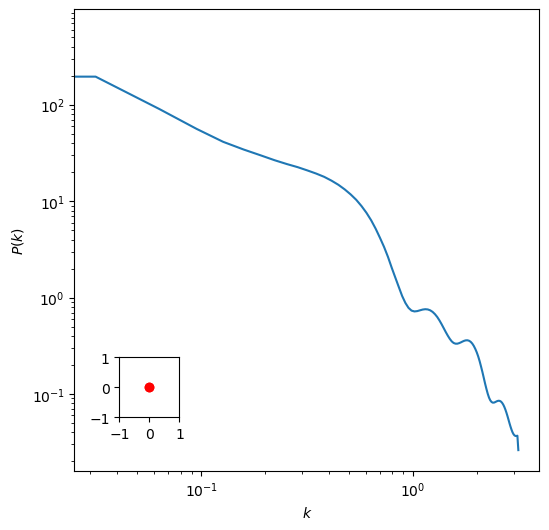

In [30]:
### Create a video of the value of the power spectrum as a function of the two cosmological parameters
### The parameters will vary between -1 and 1. 
### The power spectrum will be plotted for [-1,1] x 0 and 0 x [-1,1]
### There will be in the lower left corner a red dot that will show the current value of the parameters
### The video will be dipalyed in the notebook 
### Do not use HTML, it will not work in the notebook
import matplotlib.animation as animation


fig, ax = plt.subplots(1,1, figsize=(6,6))

plot_ps(torch.tensor([0.,0.]), ax, title = None)
### Create a small window inside with a red dot that will show the current value of the parameters
ax2 = fig.add_axes([0.2, 0.2, 0.1, 0.1])
ax2.set_xlim(-1,1)
ax2.set_ylim(-1,1)
ax2.scatter(0,0, color = "red")


## Create the animation

def animate(i):
    ax.cla()
    plot_ps(torch.tensor([i/100.,0.]), ax, title = None)
    ax2.scatter(i/100.,0, color = "red")
    return ax

ani = animation.FuncAnimation(fig, animate, frames=200, interval=20, blit=False)

